# Environmetal sound classification


<a href="https://colab.research.google.com/github/GianmarcoLattaruolo/Vision_Project/blob/main/Vision_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis




## Loading the data

Run this cell once to download the dataset.


In [49]:
import os
import shutil
import urllib
import zipfile
import glob
import urllib.request

def download_dataset(name):
    if not os.path.exists(f'./data'):
        os.mkdir('data')
    os.chdir('./data')
    """Download the dataset into current working directory.
    The labeled dataset is ESC-50, the unlabeld are ESC-US-00,ESC-US-01, ... , ESC-US-25 
    but I'm not able to download them automatically from https://dataverse.harvard.edu/dataverse/karol-piczak?q=&types=files&sort=dateSort&order=desc&page=1"""

    if name=='ESC-50' and not os.path.exists(f'./{name}'):

        if not os.path.exists(f'./{name}-master.zip') and not os.path.exists(f'./{name}-master'):
            urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}-master.zip')

        if not os.path.exists(f'./{name}-master'):
            with zipfile.ZipFile(f'{name}-master.zip','r') as package:
                package.extractall(f'{name}-master')

        os.remove(f'{name}-master.zip') 
        original = f'./{name}-master/{name}-master/audio'
        target = f'./{name}'
        shutil.move(original,target)
        original = f'./{name}-master/{name}-master/meta'
        target = f'./meta'
        shutil.move(original,target)

    if os.path.exists(f'./{name}-master'):
        shutil.rmtree(f'./{name}-master')

    else:
        print('donwload it from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YDEPUT&version=2.0')
        pass 
    os.chdir('../')


download_dataset('ESC-50')


donwload it from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YDEPUT&version=2.0


## Base Exploration of the dataset

In this cell we can listen to one random audio in our dataset (different every time we run the cell). 
Moreover we visualize a portion of the audio.


In [50]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
from scipy.io import wavfile
import seaborn as sb
sb.set(style="white", palette="muted")
import pandas as pd
import IPython.display
import random


44100
<class 'numpy.ndarray'>
(220500,)
836    insects
Name: category, dtype: object


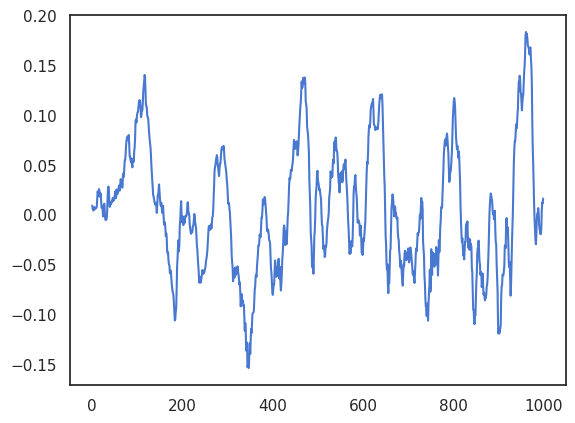

In [51]:
main_dir = os.getcwd()
dir_path = os.path.join(main_dir, 'data', 'ESC-50')
audio_files = [os.path.join(dir_path, i) for i in os.listdir(dir_path)]
i = random.randint(0,len(audio_files))
clip = audio_files[i]
samplerate = 44100
y,sr = librosa.load(clip,sr=samplerate)
# alternatively we can use wavfile.read
#samplerate * seconds_clip_audio = length_np_array

# first look at the output
print(sr)
print(type(y))
print(np.shape(y))

#load the metadata
file_path = os.path.join(main_dir, 'data', 'meta', 'esc50.csv')
meta_data = pd.read_csv(file_path)

#listen
print(meta_data.category[meta_data.filename==clip.split('/')[-1]])
display(IPython.display.Audio(data = y, rate=samplerate)  )
plt.subplot(1,1,1)
plt.plot(y[:1000])

#back to the main directory
os.chdir(main_dir)

Let's see a periodogram (power spectrum) for our clip.

Text(0.5, 76.24999999999999, 'frequency [1/second]')

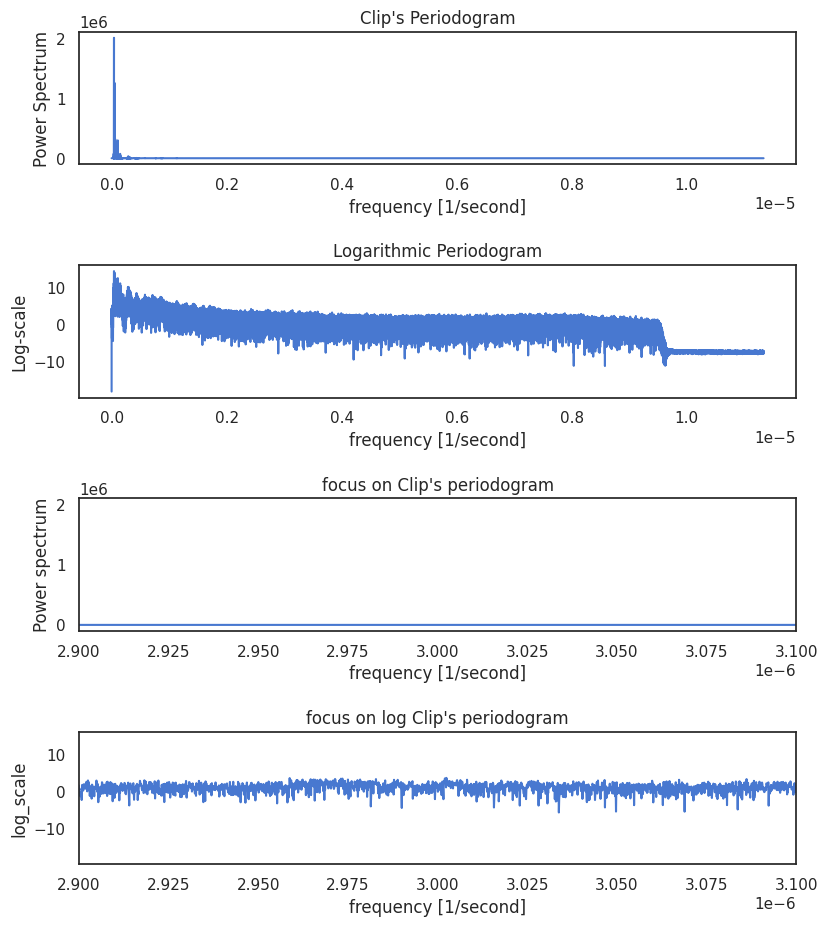

In [52]:
from scipy import signal
from scipy.fft import fft,ifft

fs = 1/sr
n = len(y)
freq_y, pow_spect_y = signal.periodogram(y,fs=fs)
#it's better to make a logarithmic plot
log_pow_spec = np.log(pow_spect_y)


plt.subplots(4, 1, figsize=(9, 10))
plt.tight_layout(pad=4)

plt.subplot(4,1,1)
plt.plot(freq_y,pow_spect_y)
plt.title("Clip's Periodogram")
plt.ylabel('Power Spectrum')
plt.xlabel('frequency [1/second]')
#it's difficult to carry out a significative graph

plt.subplot(4,1,2)
plt.plot(freq_y, log_pow_spec)
plt.title('Logarithmic Periodogram')
plt.ylabel('Log-scale')
plt.xlabel('frequency [1/second]')

plt.subplot(4,1,3)
plt.plot(freq_y,pow_spect_y)
plt.xlim([0.29*1e-5, 0.31*1e-5])
plt.title("focus on Clip's periodogram")
plt.ylabel('Power spectrum')
plt.xlabel('frequency [1/second]')

plt.subplot(4,1,4)
plt.plot(freq_y,log_pow_spec)
plt.xlim([0.29*1e-5, 0.31*1e-5])
plt.title("focus on log Clip's periodogram")
plt.ylabel('log_scale')
plt.xlabel('frequency [1/second]')

We can say that, as we expected, this type of analysis on the entire audio clip is meaningless. We'll need to fragment the audio clips.
But first let's produce some summary statistics about our dataset.

In [53]:
import time
from collections import Counter

main_dir = os.getcwd()
dir_path = os.path.join(main_dir, 'data', 'ESC-50')
audio_files = [os.path.join(dir_path, i) for i in os.listdir(dir_path)]

#load and explore the metadata
file_path = os.path.join(main_dir, 'data', 'meta', 'esc50.csv')
meta_data = pd.read_csv(file_path)
meta_data['full_path'] = meta_data.filename.apply(lambda x: os.path.join(dir_path, x))
display(meta_data.head())
print('Classes in the full dataset \n',Counter(meta_data.category)) #classes are perfectly balanced
print('The ESC-10 and ESC-50 datasets have been prearranged into 5 uniformly sized folds so that clips'+
      'extracted from the same original source recording are always contained in a single fold \n',Counter(meta_data.fold))
# 'target' is a number representing the audio type 
#category of the reduced dataset ESC-10
meta_data_esc10 = meta_data[meta_data.esc10].drop('esc10', axis=1)
display(meta_data_esc10.head())
classes_esc10 = list(set(meta_data_esc10.category))
print('Classes in ESC10 \n',classes_esc10)
#let's listen to one sample for each esc10 classes
for audio_type in classes_esc10:
    clip = list(meta_data_esc10.full_path[meta_data_esc10.category==audio_type])[0]
    data, samplerate = librosa.load(clip,sr=44100)
    print(audio_type)
    display(IPython.display.Audio(data = data, rate=samplerate)  )

#auxiliary objects
sample_rates = set()
clip_length = set()
stat_list = np.zeros((len(audio_files),4))

# let's have a look also over the copmuting time 
start_time = time.time()
for i,clip in enumerate(audio_files):
    data, samplerate = librosa.load(clip,sr=44100)
    #samplerate, data = wavfile.read(clip) 
    sample_rates.add(samplerate)
    clip_length.add(len(data))
    stat_list[i,:]=np.asarray([np.min(data),np.max(data),np.mean(data),np.std(data)])
    #the values are all between -1 and 1

print('')
print(f"librosa takes : {time.time()-start_time}")
print(f"the lengths are {clip_length}")
print(f"the sample rates are {sample_rates}")

filename  fold  target        category  esc10  src_file take  \
0   1-100032-A-0.wav     1       0             dog   True    100032    A   
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B   
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A   

                                full_path  
0   /content/data/ESC-50/1-100032-A-0.wav  
1  /content/data/ESC-50/1-100038-A-14.wav  
2  /content/data/ESC-50/1-100210-A-36.wav  
3  /content/data/ESC-50/1-100210-B-36.wav  
4  /content/data/ESC-50/1-101296-A-19.wav

Classes in the full dataset 
 Counter({'dog': 40, 'chirping_birds': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'pouring_water': 40, 'train': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'car_horn': 40, 'crackling_fire': 40, 'helicopter': 40, 'drinking_sipping': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass_breaking': 40, 'snoring': 40, 'toilet_flush': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40})
The ESC-10 and ESC-50 datasets have been prearranged into 5 uniformly sized folds so that clipsextracted fro

filename  fold  target        category  src_file take  \
0    1-100032-A-0.wav     1       0             dog    100032    A   
14   1-110389-A-0.wav     1       0             dog    110389    A   
24  1-116765-A-41.wav     1      41        chainsaw    116765    A   
54   1-17150-A-12.wav     1      12  crackling_fire     17150    A   
55  1-172649-A-40.wav     1      40      helicopter    172649    A   

                                 full_path  
0    /content/data/ESC-50/1-100032-A-0.wav  
14   /content/data/ESC-50/1-110389-A-0.wav  
24  /content/data/ESC-50/1-116765-A-41.wav  
54   /content/data/ESC-50/1-17150-A-12.wav  
55  /content/data/ESC-50/1-172649-A-40.wav

Classes in ESC10 
 ['dog', 'rooster', 'sneezing', 'crackling_fire', 'rain', 'sea_waves', 'clock_tick', 'crying_baby', 'chainsaw', 'helicopter']
dog


rooster


sneezing


crackling_fire


rain


sea_waves


clock_tick


crying_baby


chainsaw


helicopter



librosa takes : 5.594215393066406
the lengths are {220500}
the sample rates are {44100}


### Segmentation

In [54]:
def segmentation(data, sample_rate=44100, segment=25, overlapping=10):
        #segment and overlapping are expressed in milliseconds
    if type(data)=='str':
        data, samplerate = librosa.load(clip,sr=sample_rate)
        
    segment_samples = int(sample_rate * segment / 1000)  # Calculate the number of samples per segment
    overlap_samples = int(sample_rate * overlapping / 1000)  # Calculate the number of overlapping samples
    
    total_segments = (len(data) - segment_samples) // (segment_samples - overlap_samples) + 1
    
    segments = np.zeros((total_segments, segment_samples))  # Initialize an array to store the segmented data
    
    start = 0  # Starting index for each segment
    
    for i in range(total_segments):
        segments[i] = data[start:start + segment_samples]  # Assign the segment of data to the array
        
        start += segment_samples - overlap_samples  # Move the starting index forward with the overlap
    
    return segments

## Spectrogram Analysis

Now we dig in the analysis exploiting the natural structure of sound in nature. 
In particular we'll need the Short-Time Fourier Transform.

NameError: ignored

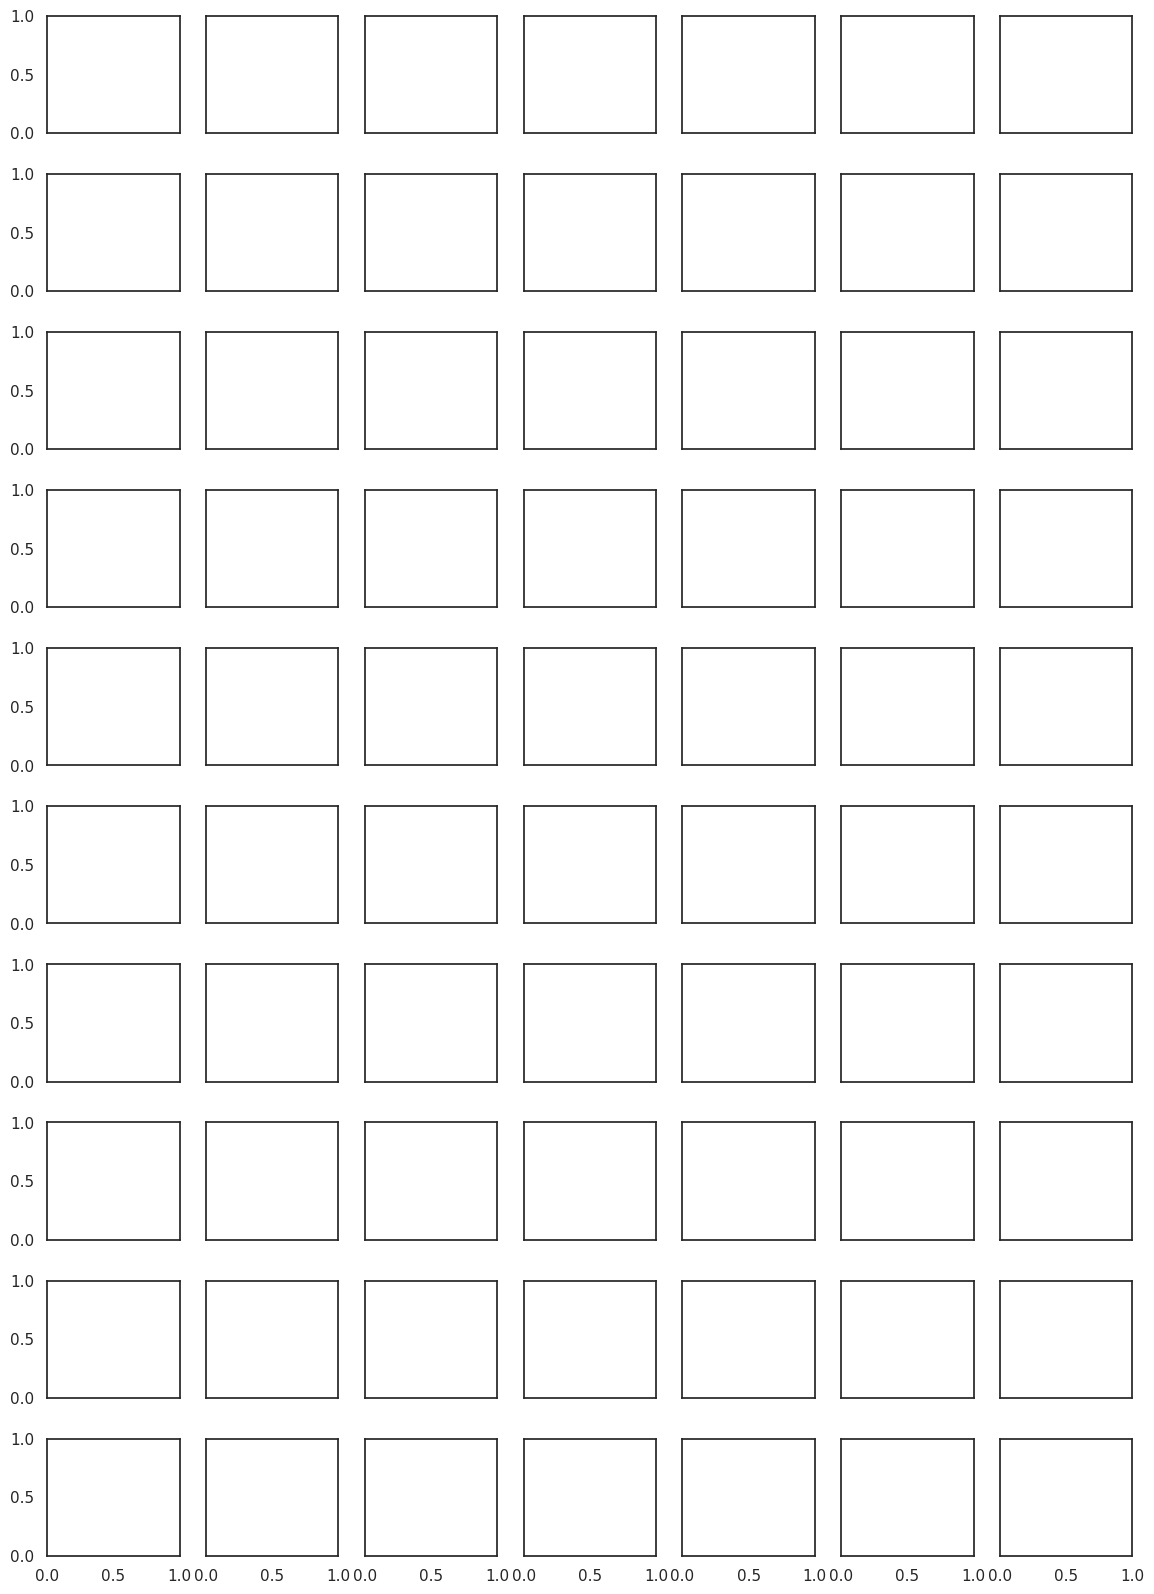

In [55]:
# questa funzione arriva dall'altro notebook...

def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)
        
        librosa.display.specshow(clip.logamplitude, sr=Clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)

categories = 10
clips_shown = 7
f, axes = plt.subplots(categories, clips_shown, figsize=(clips_shown * 2, categories * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c in range(0, categories):
    for i in range(0, clips_shown):
        plot_clip_overview(clips_10[c][i], axes[c, i])

In [ ]:
fig, ax = plt.subplots()
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(data=S_db, sr=sr,ax=ax)
fig.colorbar(img, ax=ax)



## Auxiliary Classes

In [ ]:

class Clip():
    """A single 5-sec long recording."""
    
    samplerate = 44100   # All recordings in ESC are 44.1 kHz
    frame = 512    # Frame size in samples
    
    def __init__(self, path):
        self.path = path
        y,sr = librosa.load(self.path,sr=samplerate)
        self.raw = y
        

    #cosa vogliamo che faccia la classe che fa il load della singola clip audio?
